In [1]:
# ffmpeg -i additional/2022-11-12\ 14-53-12.mp4  /tmp/out%05d.png
from PIL import Image, ImageDraw, ImageColor
import numpy as np

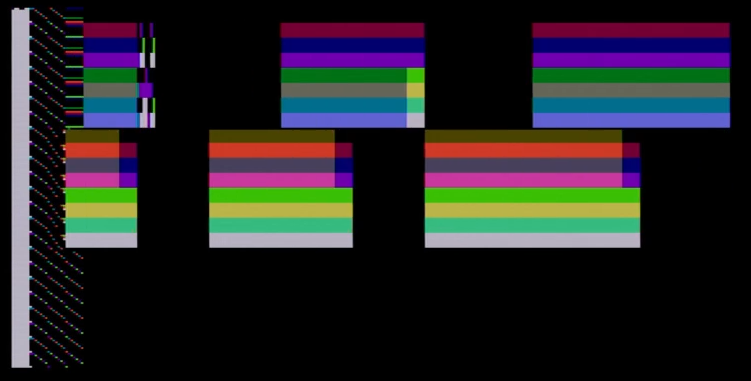

In [2]:
img = Image.open("fenarinarsa_chat_mauve.png")
img

(960, 720)


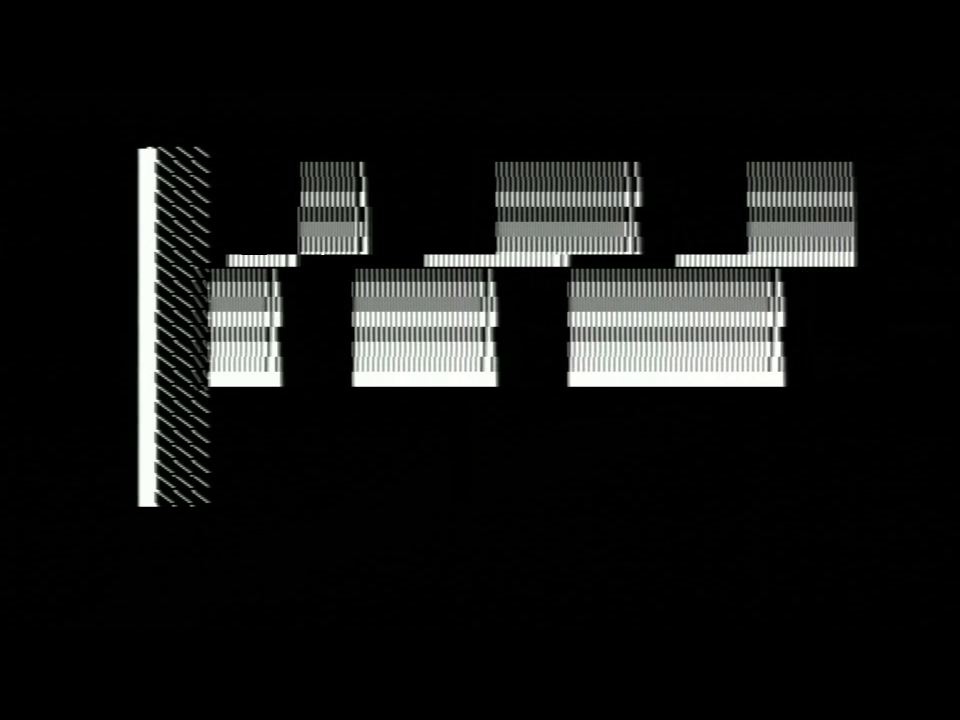

In [3]:
org_img = Image.open("capture1.png")
print(org_img.size)
org_img


In [4]:

a = np.asarray(org_img).copy()
a.shape
for i in range(12, a.shape[0] - 16, 15):
    r = a[i+13:i+15,:].copy()
    a[i+2:i+15,:] = a[i:i+13,:]
    a[i+0:i+2,:] = r
    
    a[i,101,:] = 127 
    a[i+1,101,:] = 127 

img2 = Image.fromarray(a)
#img2 = org_img


C:\Users\StephaneC\AppData\Local\Temp\ipykernel_7724\3029947211.py:11: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.resize( (img.width*zoom,img.height*zoom), Image.NEAREST )


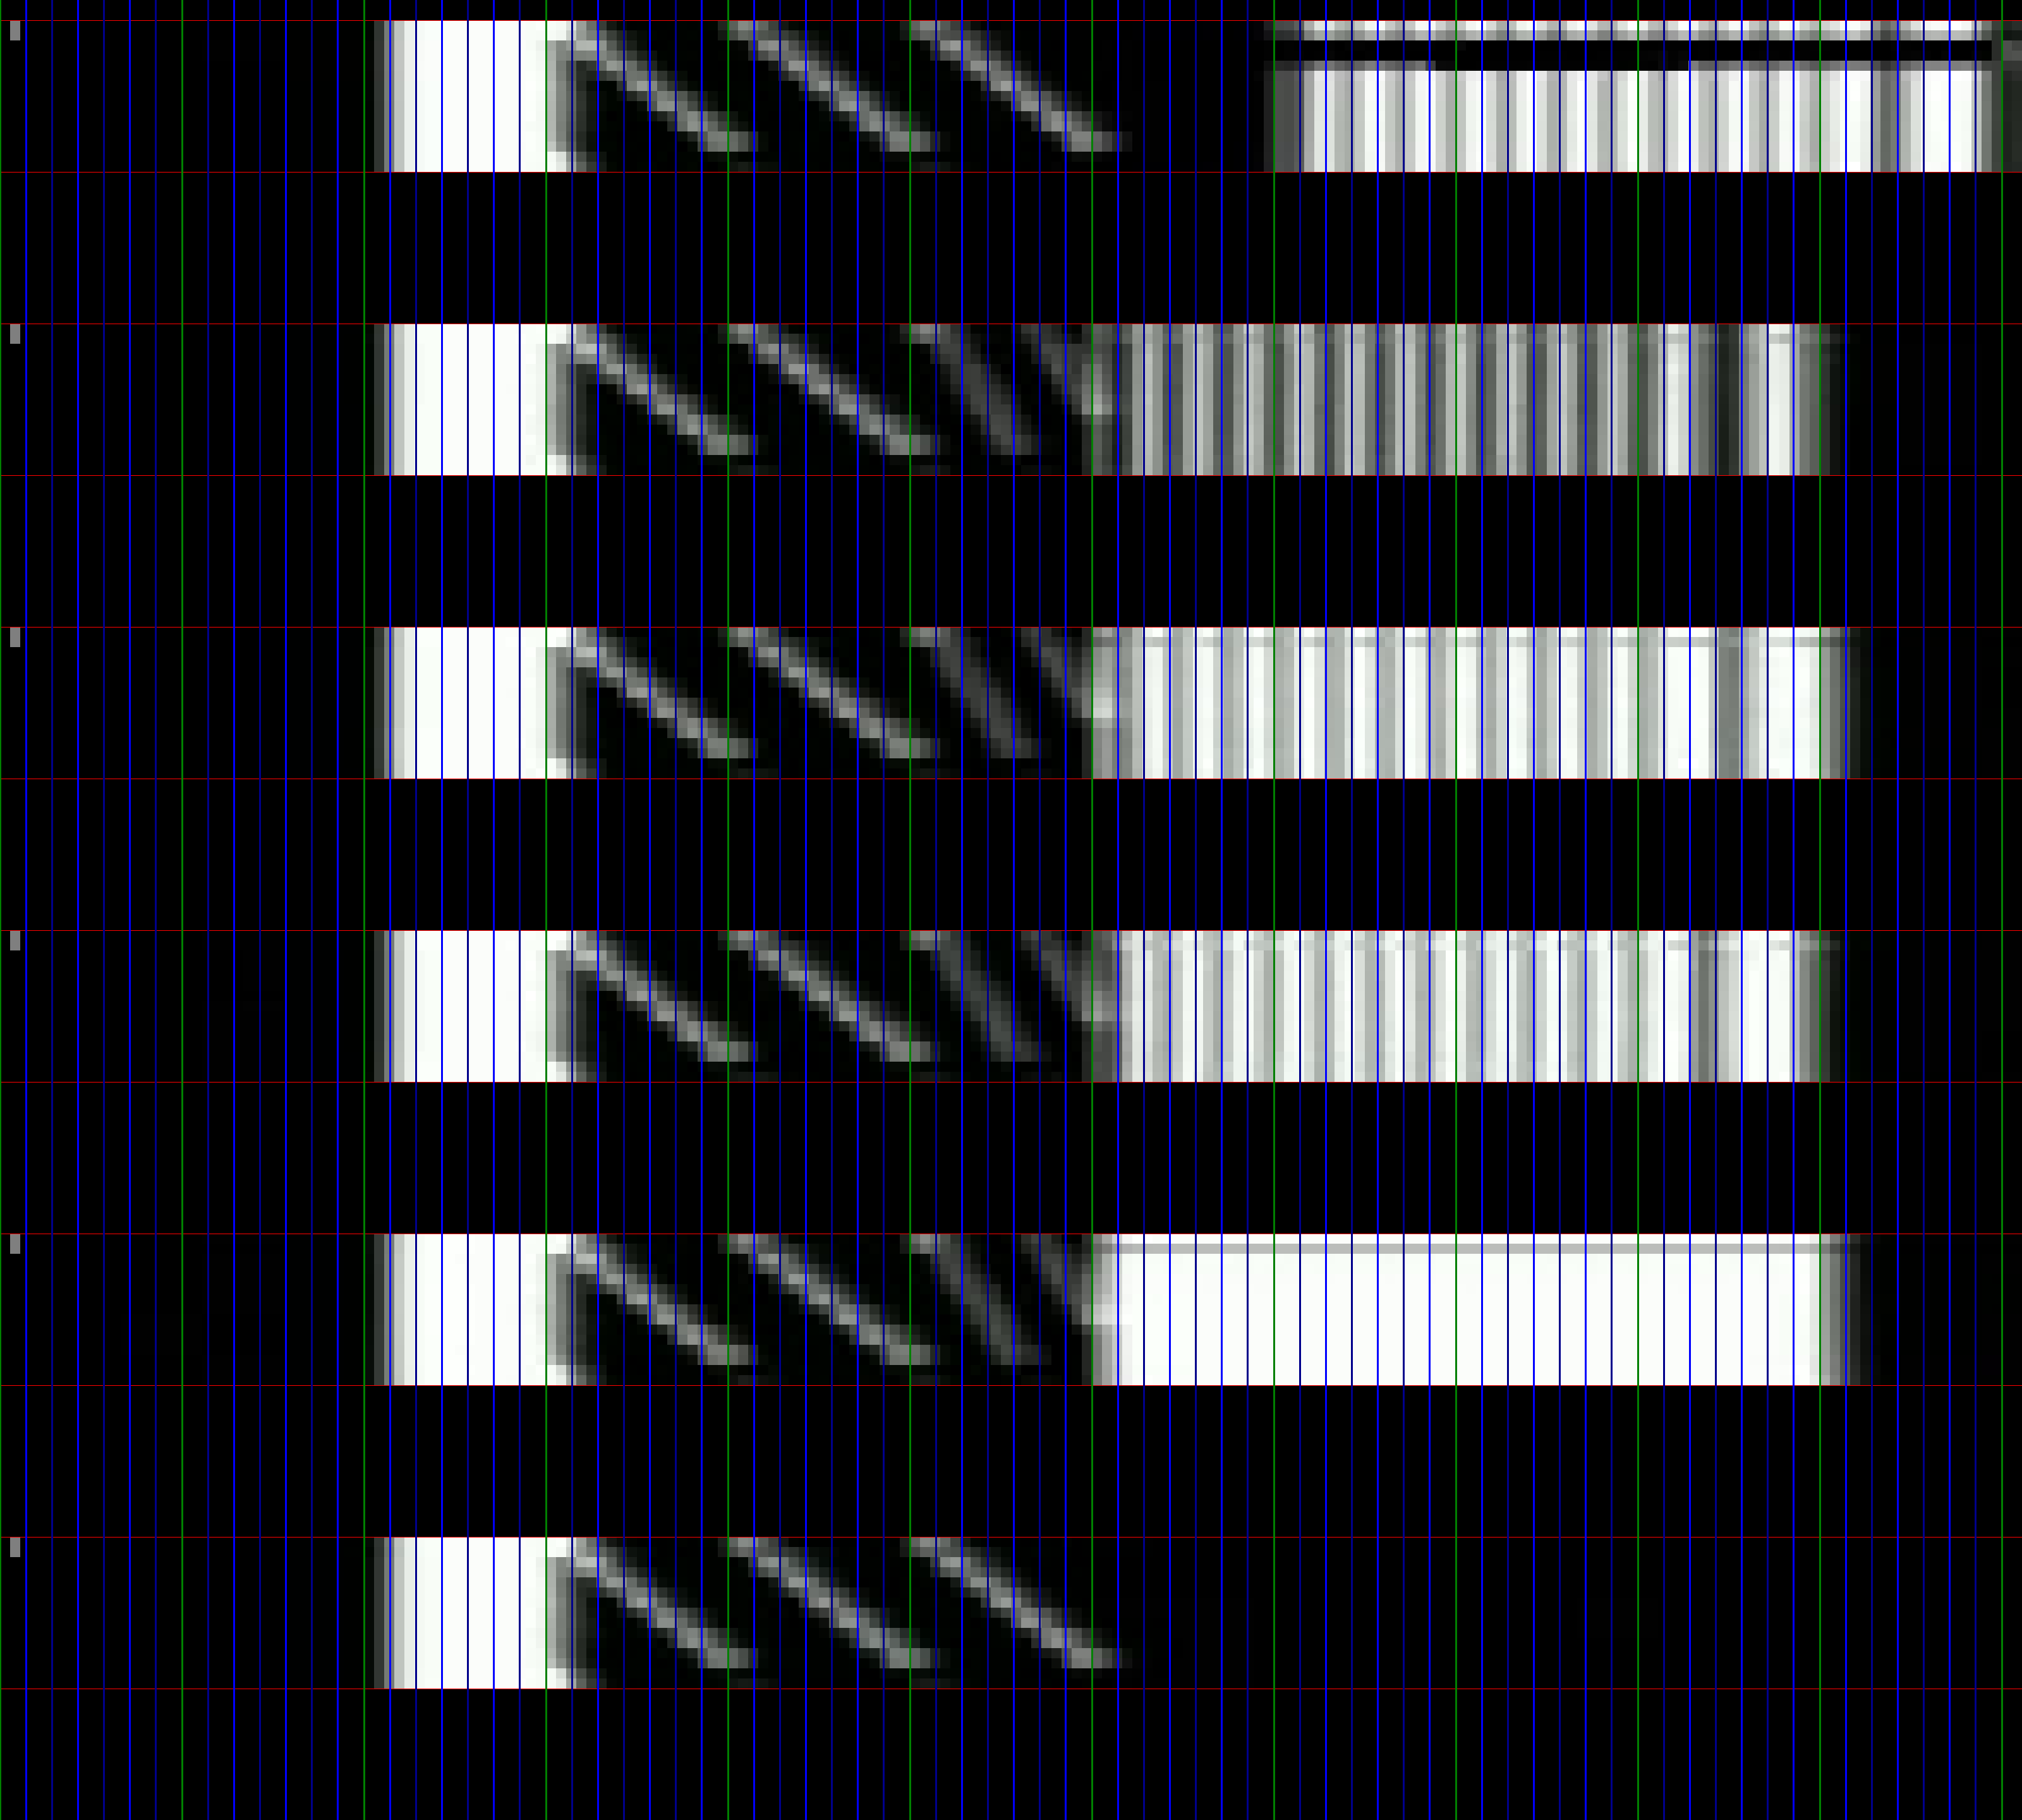

In [5]:
from PIL import ImageFilter
img = img2
#img = img2.filter(ImageFilter.SHARPEN).filter(ImageFilter.SHARPEN)



zoom = 16



img = img.resize( (img.width*zoom,img.height*zoom), Image.NEAREST )
draw = ImageDraw.Draw(img)

# On fenarinarsa video, the lines seems to be interpolated. I remove
# the interpolated lined to make the rest more apparent.
#for y in range(0,img.height,2):
#    draw.rectangle( (0,y*zoom,img.width,(y+1)*zoom), ImageColor.getrgb("Black"))

for y in range(1,30,2):
    b = 12*zoom + 15*zoom*y
    draw.rectangle( (0,b,img.width,b+15*zoom), ImageColor.getrgb("Black"))


for y in range(12*zoom,img.height,15*zoom):
    draw.line( (0,y,img.width,y), ImageColor.getrgb("Red"))

for i in range(-100,100):
    # This will start for the green/mauve blocks (which are not shifted
    # by one 14MHz cycle; unlike the blue/red)
    x = 190*zoom + 18/7*i*zoom
    if i % 7 == 0:
        color = ImageColor.getrgb("green")
    elif (i % 14) % 2 == 0:
        color = ImageColor.getrgb("Blue")
    elif (i % 14) % 2 == 1:
        color = ImageColor.getrgb("DarkBlue")

    draw.line( (x,0,x,img.height), color, width=3)



w,h=200,180
img.crop((100*zoom,250*zoom,(100+w)*zoom,(250+h)*zoom))

# hgr_part = [bits[0], bits[0]] # 2 bits
# gr_part1 = bits[1:7] # 6 bits
# gr_part2 = [bits[3]] + bits[0:4] + bits[0:2] # 6 bits

In [6]:
HGR = 1
GR = 2

class Scanner:
    def __init__(self, memory):
        self._memory = memory
        self._ofs = 0

    def scan(self):
        b = self._memory[self._ofs]
        self._ofs += 1
        

class Shifter:
    def __init__(self) -> None:
        self._byte = 0
        self._clock = 0
        self._mode = GR
        self._flip_flop = 0
        self._two_shifters = False
        self._read_Q2 = False

    @property
    def mode(self):
        return self._mode

    def set_mode(self, mode, line, x=0):
        assert mode in (GR,HGR)
        self._mode = mode
        self._line = line
        self._read_Q2 = x & 1 == 1

    def even_line(self):
        return (self._line // 4) & 1 == 0

    def shift(self):
        
        if self._mode == HGR:
            if self._clock & 1 == 1:
                self._byte = (self._byte >> 1) | ((self._byte & 1) << 7)
        else:
            if self._two_shifters:
                if self.even_line():
                    b = self._byte & 0b1111
                    b = (b >> 1) | ((b & 1) << 3)
                    self._byte = (self._byte & 0b1111_0000) | b
                else:
                    b = (self._byte >> 4) & 0b1111
                    b = (b >> 1) | ((b & 1) << 3)
                    self._byte = (self._byte & 0b0000_1111) | (b << 4)
            else:
                self._byte = (self._byte >> 1) | ((self._byte & 1) << 7)

        self._clock += 1

    def Q2_or_Q0(self,b):
        if self._read_Q2:
            return (b >> 2) & 1
        else:
            return b & 1

    def read_and_shift(self, n, debug=False):
        assert n > 0
        r = []
        for i in range(n):

            if self._mode == HGR:
                self._flip_flop = self._byte & 1
            elif self._mode == GR:
                if self._two_shifters:
                    if self.even_line():
                        self._flip_flop = self.Q2_or_Q0(self._byte)
                    else:
                        self._flip_flop = self.Q2_or_Q0(self._byte >> 4)
                else:
                    self._flip_flop = self.Q2_or_Q0(self._byte)

            if debug:
                m = ["HGR","GR"][self._mode-1]
                print(f"R&S: {m}: {self._byte >> 4:04b}_{self._byte & 0b1111:04b} -> {self._flip_flop}")

            r.append(self._flip_flop)
            self.shift()

        return r

    def latch(self, b, debug=False):
        if debug:
            print(f"Latch: {b:08b}")
        self._byte = b        

    def video_out(self):
        return self._flip_flop

    def clock_hgr(self, b, nb_cycles=14):
        signal = []

        if b & 0x80 == 0:
            assert self._clock % 14 == 0
            self.latch(b)
            signal.extend(self.read_and_shift(14))
        else:
            assert self._clock % 14 == 0
            signal.extend([self.video_out()])                
            self.latch(b)
            signal.extend(self.read_and_shift(13))
            self.shift() 

        return signal       
        
    def latch_gr(self,y,x,src, debug=False):

        if self.even_line():
            b = src & 0b1111
        else:
            b = (src >> 4) & 0b1111

        if debug:
            print(f"latch: {b:08b}")

        if self._two_shifters:
            # This is needed to align on COLOR_REF (although I didn't find anything babout that in my documentation)
            b = ((b << 1) & 0b1111) | (b >> 3)

            if x & 1 == 1:
                self._read_Q2 = True
                b = (b >> 1) | ((b & 1) << 3)
                b = (b >> 1) | ((b & 1) << 3)
            else:
                self._read_Q2 = False

            if self.even_line():
                if debug:
                    print(f"latch: even line {b:08b}")
                self._byte = (self._byte & 0b1111000) | b
            else:
                self._byte = (self._byte & 0b00001111) | (b << 4)
        else:
            b = (b << 4) | b
            b = rol(b)
            if x & 1 == 1:
                self._read_Q2 = True
                #b = ror( ror( b))
            else:
                self._read_Q2 = False

            self._byte = b

        if debug:
            print(f"latch GR y={y}/{self._line}, source : {src:08b} -> shifter:{self._byte:08b}")

    def clock_gr(self, y, x, b):
        signal = []

        if (y // 4) & 1 == 0:
            b = b & 0b1111
        else:
            b = (b >> 4) & 0b1111
            
        b = (b << 4) | b
        b = rol(b) # This is needed to align on COLOR_REF (although I didn't find anything babout that in my documentation)

        if x & 1 == 1:
            self._read_Q2 = True
            #b = ror(ror(b))
        else:
            self._read_Q2 = False

        self.latch(b)
                        
        signal.extend( self.read_and_shift(14))
        return signal



ROL
2 times bit out
LOOP 12:
   ROL
   1 time bit out

In [7]:
with open("oldskool.hgr",'rb') as fin:
    hgr = fin.read()

with open("oldskool.gr",'rb') as fin:
    gr = fin.read()

apple_memory = [0] * 65536
apple_memory[0x0400:0x0800] = gr
apple_memory[0x2000:0x4000] = hgr


In [8]:
with open("screen.hgr",'rb') as fin:
    hgr = fin.read()

with open("screen.gr",'rb') as fin:
    gr = fin.read()

apple_memory = [0] * 65536
apple_memory[0x0800:0x0C00] = gr
apple_memory[0x2000:0x4000] = hgr


In [9]:
import numpy as np
from math import sin, cos

PI=   3.14159265358979323846
TAU=  6.28318530717958647693

#  TV-like adjustments
SAT = 1.0      #  Saturation / "Color" (normally 1.0)
HUE = 0.0      #  Hue / "Tint" (normally 0.0)
BRI = 1.0      #  Brightness (normally 1.0)

#  Filter parameters
N   = 15       #  Filter Width
M   = N//2      #  Filter Middle
FC  = 0.25     #  Frequency Cutoff
SCF = 0.25     #  Subcarrier Frequency

YIQ2RGB = np.array( [ [1.000, 1.000, 1.000],
                          [0.956,-0.272,-1.106],
                          [0.621,-0.647, 1.703] ]).transpose()

def hann(n, N):
    return 0.5 * (1.0 - cos((TAU*n)/(N-1.0)))


def sinc(x):
    if (x == 0.0):
        return 1.0
    return sin(PI*x) / (PI*x)

def qam_xot():
    weights = np.zeros((N,))
    for n in range(N):
        weights[n] = hann(float(n), float(N)) * sinc(FC * float(n-M))

    #  Normalize sampling weights
    weights = weights / np.sum(weights)

    #phase = TAU * (SCF * size.x * pos.x);
    phase = TAU * SCF * np.arange(560)
    sin_phase = np.sin(phase)
    cos_phase = np.cos(phase)

    return weights, sin_phase, cos_phase


xot_weights, xot_sin_phase, xot_cos_phase = qam_xot()

def unqam(line):
    s = xot_sin_phase * line
    c = xot_cos_phase * line

    pixels = []
    for x in range(N,len(line)-N):
        Y = line[x:x+N] * 1.0 * xot_weights
        I = c[x:x+N] * xot_weights
        Q = s[x:x+N] * xot_weights

        rgb = np.matmul(YIQ2RGB, np.array([np.sum(Y),np.sum(I),np.sum(Q)]))
        pixels.append(rgb)
    #return np.hstack(np.clip(pixels,0,1))*255
    return np.clip(np.array(pixels),0,1)*255

# New optimisation loop

Here I test a new way to build the main rendernig loop. The goal is to have something that is easier to read and debug. For that I forego some ooptimizations.

(192, 560)


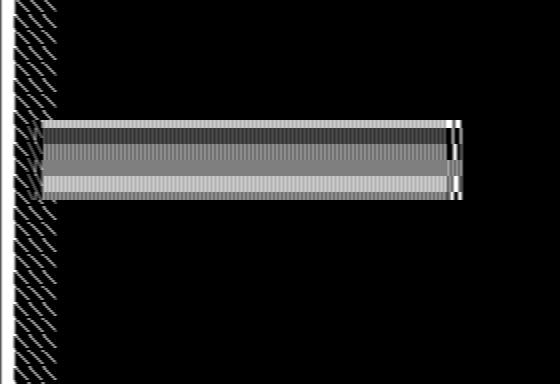

In [41]:
from utils import *
from enum import Enum

class ModeType(Enum):
    HGR = 1
    GR = 2

class Mode:
    def __init__(self,mode_type, page):
        assert page in (1,2)

        self._mode_type = mode_type
        self._page = page

    @property
    def type(self):
        return self._mode_type

    @property
    def base_address(self):
        if self._mode_type == ModeType.HGR:
            if self._page == 1:
                return 0x2000
            else:
                return 0x4000
        elif self._mode_type == ModeType.GR:
            if self._page == 1:
                return 0x400
            else:
                return 0x800



class EventType(Enum):
    MODE_CHANGE=1
    WRITE_MEM=2

class Event:
    def __init__(self, type, value, cycle):
        self._type = type
        self._value = value
        self._cycle = cycle

    @property
    def type(self):
        return self._type

    @property
    def value(self):
        return self._value

    @property
    def cycle(self):
        return self._cycle

class Scanner:
    def __init__(self):
        self._mode = None

    def set_mode(self, mode):
        self._mode = mode

    def set_on_line(self, line):
        self._line = line
        self._x = 0

    def tick(self, memory):
        ofs = self._mode.base_address
        if self._mode.type == ModeType.HGR:
            ofs += hgr_address(self._line)
        elif self._mode.type == ModeType.GR:
            ofs += text_address(self._line)
        else:
            raise Exception("Unknown mode")

        r = memory[ofs + self._x]
        self._x += 1
        return r


class Shifter:
    def __init__(self):
        self._mode = None
        self._byte = 0

    def set_mode(self, mode: Mode):
        self._mode = mode

    def set_on_line(self, line):
        self._last_bit_out = 0
        self._line = line
        self._shift = 0

    def load_byte(self, byte, cycle):
        if self._mode.type == ModeType.HGR:
            
            self._byte = byte
            self._shift = (byte & 0x80) != 0

        elif self._mode.type == ModeType.GR:

            if (self._line // 4) & 1 == 0:
                val = (byte & 0b1111)
            else:
                val = ((byte & 0b11110000) >> 4)

            # Doesn't work (to prenvent initial 1/4 phase shift)
            # val = ((val & 1) << 3) + ((val & 2) << 1) + ((val & 4) >> 1) + ((val & 8) >> 3)

            val = (val << 4) | val
            if cycle & 1 == 0:
                val = ror(ror(val))

            self._byte = val

    def tick(self, cycle):
        byte = self._byte
        memory = []
        if self._mode.type == ModeType.HGR:
            """
            8 bits: bit 7 says shift or not.
            Bit 6-0 are output doubled (so 14 small pixels)
            one needs two bits to make a full pixel.
            so A0,A1; A2,A3; A4,A5; A6- and one is missing one bit to
            complete the pixel. SO one needs another byte B:
            A0,A1; A2,A3; A4,A5; A6-B0; B1,2; B3,4; B5,6

            But there's the shift too:
            no shift: A0011; A2233; A4455; A66B00; B1122; B3344; B5566
            shift:    A0011; A2233; A4455; A666B00; B1122; B3344; B556
            """
            shift = (byte & 0x80) != 0

            if shift:
                memory.append(self._last_bit_out)

            for i in range(6):
                bit = byte & 1
                memory.extend([bit,bit])                
                byte = byte >> 1

            bit = byte & 1
            if not shift:
                memory.extend([bit, bit])
            else:
                memory.append(bit)

            self._last_bit_out = bit

        elif self._mode.type == ModeType.GR:
                
            # Sather says one has to invert the signal. But if
            # I do so, of course, the white becomes black and
            # vice versa...
            #val = (val ^ 0xFF) & 0xFF
            
            if self._shift:
                memory.append(self._last_bit_out)

            for i in range(13):
                byte = ror(byte)
                bit = byte & 1
                memory.append(bit)

            if not self._shift:
                byte = ror(byte)
                bit = byte & 1
                memory.append(bit)

            self._last_bit_out = bit                
            self._shift = False
        else:
            raise Exception("Unsupported mode")

        assert len(memory) == 14
        return memory


def apply_event( event, memory, scanner, shifter):
    if event.type == EventType.MODE_CHANGE:
        if event.value.type == ModeType.HGR:
            shifter._byte = rol(shifter._byte)
        else:
            #shifter._byte = rol(rol(shifter._byte))
            shifter._last_bit_out = shifter._byte & 1
            shifter._byte = shifter._byte
            shifter._shift = True

        scanner.set_mode(event.value)
        shifter.set_mode(event.value)

def apply_event_up_to_cycle(events, last_cycle, memory, scanner, shifter):
    while events and events[0].cycle < last_cycle:
        apply_event(events[0], memory, scanner, shifter)
        del events[0]

frame_start_cycle = 0

#events = [ Event(EventType.MODE_CHANGE, Mode(ModeType.HGR, 2), 1)]
# for i in range(110,140):
#     line_cycle = frame_start_cycle + 65*i
#     events.append(Event(EventType.MODE_CHANGE, Mode(ModeType.HGR, 2), line_cycle+17))
#     events.append(Event(EventType.MODE_CHANGE, Mode(ModeType.GR, 2), line_cycle+42))
#events.append(Event(EventType.MODE_CHANGE, Mode(ModeType.HGR, 2), line_cycle+65))

events = [ Event(EventType.MODE_CHANGE, Mode(ModeType.HGR, 1), 1)]
for i in range(60,100):
    line_cycle = frame_start_cycle + 65*i
    events.append(Event(EventType.MODE_CHANGE, Mode(ModeType.GR, 2), line_cycle+12))
    events.append(Event(EventType.MODE_CHANGE, Mode(ModeType.HGR, 1), line_cycle+42))


shifter = Shifter()
scanner = Scanner()
screen_bytes = []

# Top lines of the screen don't display anything
apply_event_up_to_cycle(events, 100, apple_memory, scanner, shifter)


# Center of the screen is wher we display something.
for line in range(192):
    line_start_cycle = frame_start_cycle + line*65
    visible_line_start = line_start_cycle + 10
    line_end = line_start_cycle + 65

    # optimizing line redraw is hard:
    # - they must have no events
    # - their gfx mode must have not changed
    # - their memory must have not changed

    # First part of the line is invisible
    apply_event_up_to_cycle(events, visible_line_start, apple_memory, scanner, shifter)

    # Second part of the line is visible
    scanner.set_on_line(line)
    shifter.set_on_line(line)
    line_bytes = []
    for cycle in range(40):
        cpu_cycle = line_start_cycle + 10 + cycle
        
        scanned_byte = scanner.tick(apple_memory) # the scanner will use the ROM in text mode
        shifter.load_byte(scanned_byte, cycle)

        if events and events[0].cycle == cpu_cycle:
            apply_event(events[0], apple_memory, scanner, shifter)
            del events[0]

        line_bytes.extend(shifter.tick(cycle))

    assert len(line_bytes) == 14*40
    # Third part of the line is invisible
    apply_event_up_to_cycle(events, line_end, apple_memory, scanner, shifter)

    screen_bytes.append(line_bytes)
# Bottom lines of the screen don't display anything
apply_event_up_to_cycle(events, 20280, apple_memory, scanner, shifter)

screen =  np.array(screen_bytes, dtype=float) 
for y in range(192):
    screen[y,:] = np.convolve(screen[y,:], np.array([0.1,0.25,0.3,0.25,0.1]), "same" )
print(screen.shape)

from PIL import Image, ImageFilter

Image.fromarray((screen*255).astype(np.ubyte), mode="L").resize((560,192*2), Image.Resampling.NEAREST) #.filter(ImageFilter.BoxBlur(1))


(960, 720)


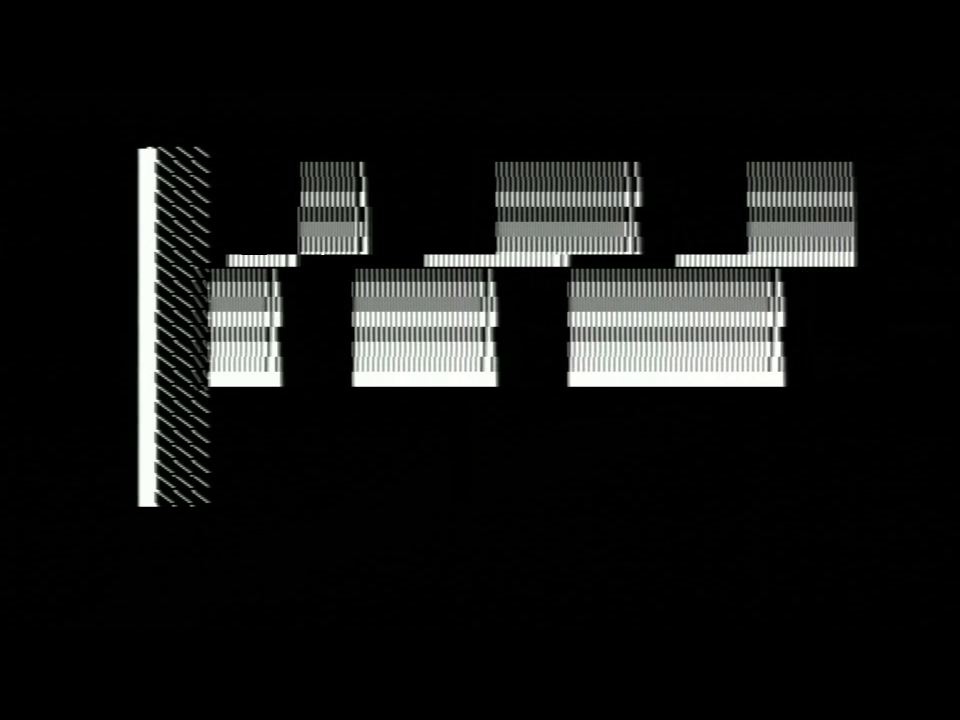

In [42]:
org_img = Image.open("capture1.png")
print(org_img.size)
org_img

C:\Users\StephaneC\AppData\Local\Temp\ipykernel_7724\964127795.py:5: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  Image.fromarray(np.array(colored_screen_bytes).astype(np.ubyte), mode="RGB").resize((screen.shape[1], 2*screen.shape[0]), Image.NEAREST)


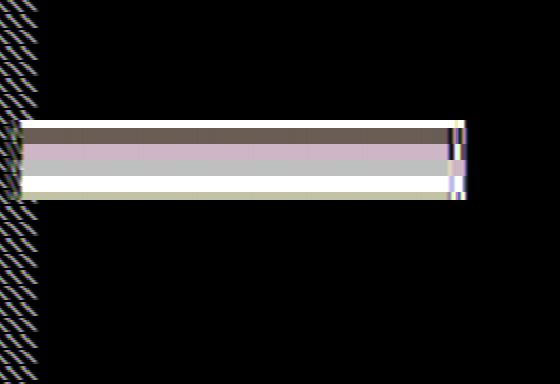

In [44]:
colored_screen_bytes = []
for y in range(192):
    colored_screen_bytes.append(unqam(screen[y,:]*1.5))

Image.fromarray(np.array(colored_screen_bytes).astype(np.ubyte), mode="RGB").resize((screen.shape[1], 2*screen.shape[0]), Image.NEAREST)    